# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [63]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [64]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [65]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [66]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.output = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_2(self.layer_1(x))


    return self.output(x, activation=1)

In [67]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    prediction = tf.math.argmax(y_pred, axis=1)
    equality = tf.math.equal(prediction, tf.cast(y_true, tf.int64))
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float64))
    return accuracy

In [68]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)#Why?

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    w1, b1 = neural_net.layer_1.w, neural_net.layer_1.b
    w2, b2 = neural_net.layer_2.w, neural_net.layer_2.b
    w3, b3 = neural_net.output.w, neural_net.output.b
    # Обчислимо за ними значення градієнта
    w1g, b1g, w2g, b2g, w3g, b3g = g.gradient(loss, [w1, b1, w2, b2, w3, b3])

    # Модифікуємо параметри
    neural_net.layer_1.w.assign_sub(learning_rate * w1g)
    neural_net.layer_1.b.assign_sub(learning_rate * b1g)
    neural_net.layer_2.w.assign_sub(learning_rate * w2g)
    neural_net.layer_2.b.assign_sub(learning_rate * b2g)
    neural_net.output.w.assign_sub(learning_rate * w3g)
    neural_net.output.b.assign_sub(learning_rate * b3g)

In [69]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append(cross_entropy(pred, batch_y))
        accuracy_history.append(accuracy(pred, batch_y))


C:\Users\Alex\AppData\Local\Temp\ipykernel_6092\3958595049.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


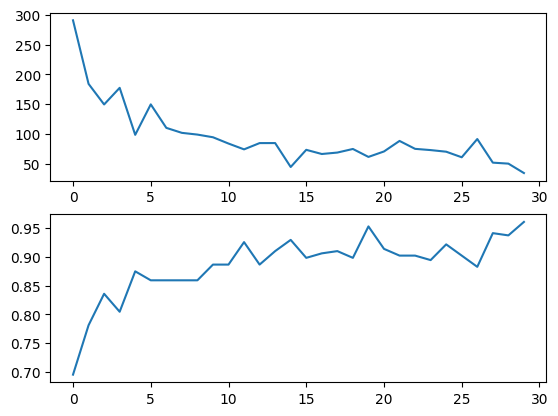

In [70]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)

# Виведіть графік функції втрат
axs[0].plot(loss_history)

# Виведіть графік точності
# Місце для вашого коду
axs[1].plot(accuracy_history)

fig.show()

In [79]:
# Обчисліть точність навченої нейромережі
tf.print("accuracy: ", accuracy(neural_net(x_test), y_test))
# Тестування моделі на тестових даних
# Це не одне і те саме? Точність нейронної мережі на тестових даних.

accuracy:  0.9045


[7]


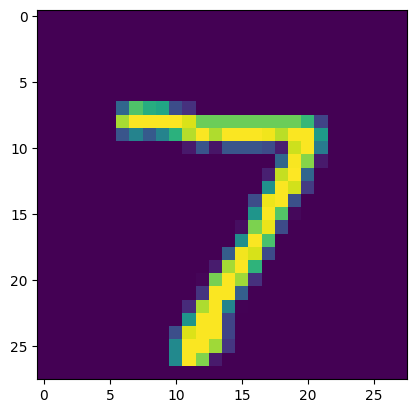

[2]


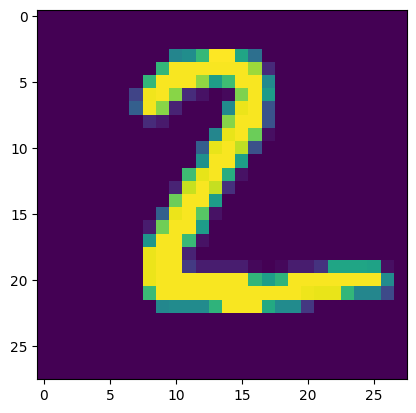

[1]


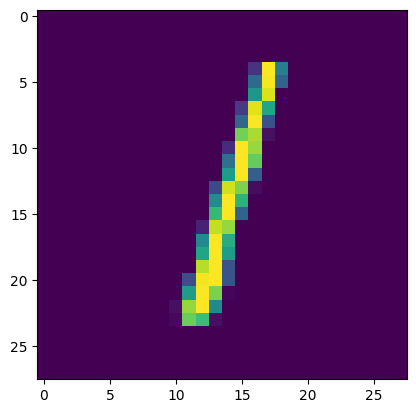

[0]


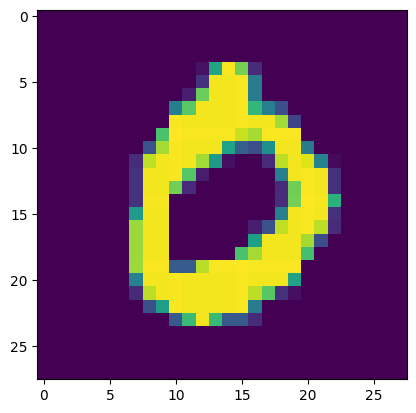

[4]


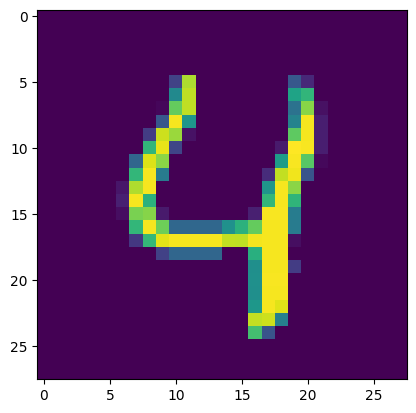

[1]


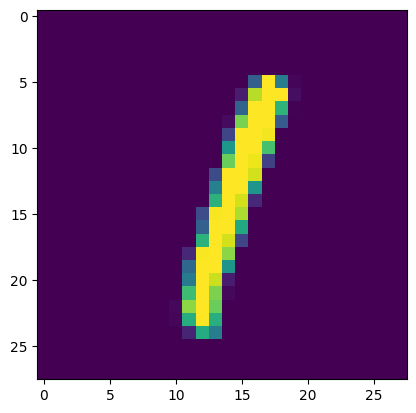

[4]


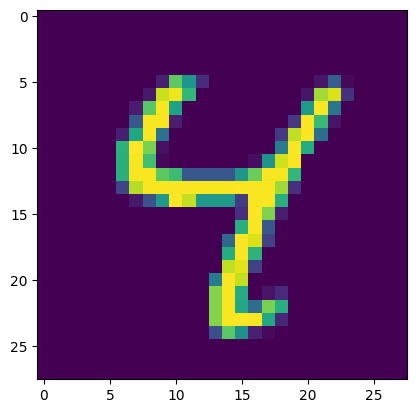

[8]


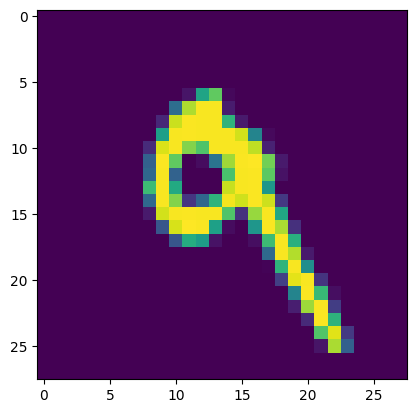

[6]


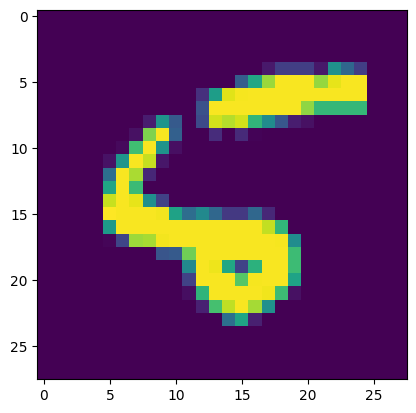

In [84]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.

# Протестуйте на десяти зображеннях, взявши 5 з тестової вибірки? То 10 чи 5?

# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

images = x_test[0:9]
for i in images:
    i2d = i.reshape((28, 28))
    plt.imshow(i2d)
    number = tf.math.argmax(neural_net([i]), axis=1)
    tf.print(number)
    plt.show()
# Так, звісно вона помиляється. Точність 0.90, одже вона помиляється один раз з десяти.
# З обраних десяти зображеннь мережа один раз помилилась. І я не зміг сам розпізнати одну цифру.